# **Homework 3 - Places of the world**
---

In [122]:
from sklearn.feature_extraction.text import TfidfVectorizer
from bs4 import BeautifulSoup as bs
from matplotlib import pyplot as plt
from collections import Counter
from numpy.linalg import norm 
from datetime import datetime
from functools import reduce
from tqdm import tqdm
import random as rdm
import pandas as pd
import numpy as np
import requests
import string
import pickle
import time
import nltk
import bs4
import os
import re



## **1. Data collection**

### 1.1. Get the list of places

In [ ]:
with open('Places_url.txt', 'x') as f:
    for i in tqdm(range(1,401)):             
        url = f'https://www.atlasobscura.com/places?page={i}&sort=likes_count'
        result = requests.get(url)
        soup = bs(result.text)
        matches = soup.find_all("a", {"class": "content-card content-card-place"})
        for match in matches:
            f.write(match['href'] + '\n')

### 1.2. Crawl places

In [ ]:
os.mkdir(f'Locations')
places_url = pd.read_csv(os.getcwd()+'/Places_url.txt', header=None)


for page in tqdm(range(0,400)):
    os.mkdir(f'Locations/page_{page + 1}')
    for loc in range(0,18):
        with open(os.getcwd()+'/Locations/page_'+str(page+1)+'/location_'+str(18*page+loc+1)+'.html', 'w', encoding="utf-8") as f:
            url = 'https://www.atlasobscura.com' + places_url.iloc[(18 * page) + loc][0]
            result = requests.get(url)
            html = result.text
            f.write(html)

100%|██████████| 9/9 [01:33<00:00, 10.44s/it]


### 1.3 Parse downloaded pages

In [ ]:
# Get all the data for one place in a dataframe
# input : String corresponding to the html_file
# output : dataframe containing all the data scraped 
def get_data_for_one_place(html_file):

    soup = bs(html_file)

    df = pd.DataFrame(columns=['placeName','placeTags','numPeopleVisited','numPeopleWant','placeDesc','placeShortDesc','placeNearby','placeAddress','placeAlt','placeLong','placeEditors','placePubDate','placeRelatedLists','placeRelatedPlaces','placeURL']) 

    placeName = soup.find('h1', {'class':'DDPage__header-title'})
    if placeName is not None :
        df['placeName'] = [placeName.text]
    else :
        df['placeName'] = ''

    placeTags = soup.find('div', {'class':'DDPage__header-place-location'})
    if placeTags is not None :
        df['placeTags'] = placeTags.text
    else :
        df['placeTags'] = ''

    L = soup.find_all('div', {'class':'col-xs-4X js-submit-wrap js-been-to-top-wrap action-btn-col hidden-print'})
    if L is not None and len(L)!=0 and L[0].find('div', {'class':'title-md item-action-count'}) is not None :
        df['numPeopleVisited'] = int(L[0].find('div', {'class':'title-md item-action-count'}).text)
    else :
        df['numPeopleVisited'] = ''

    L = soup.find_all('div', {'class':'col-xs-4X js-submit-wrap js-like-top-wrap action-btn-col hidden-print'})  
    if L is not None and len(L)!=0 and L[0].find('div', {'class':'title-md item-action-count'}) is not None :
        df['numPeopleWant'] = int(L[0].find('div', {'class':'title-md item-action-count'}).text)
    else :
        df['numPeopleWant'] = ''

    placeDesc = soup.find('div', {'id':'place-body'})
    if placeDesc is not None :
        df['placeDesc'] = placeDesc.text.replace('\n',' ').replace(u'\xa0',u' ')
    else :
        df['placeDesc'] = ''
    
    placeShortDesc = soup.find('h3', {'class': 'DDPage__header-dek'})
    if placeShortDesc is not None :
        df['placeShortDesc'] = placeShortDesc.text.replace('\n',' ').replace(u'\xa0',u' ')
    else :
        df['placeShortDesc'] = ''

    placeNearby = set([match.text for match in soup.find_all('div', {'class': 'DDPageSiderailRecirc__item-title'})])
    if len(placeNearby) != 0 :
        df['placeNearby'] = ','.join(list(placeNearby))
    else :
        df['placeNearby'] = ''

    match_address = soup.find("address", {"class":"DDPageSiderail__address"})
    if match_address is not None :
        placeAddress = match_address.find('div').contents[0:5:2]
        df['placeAddress'] = "".join(placeAddress).replace('\n','')
    else :
        df['placeAddress'] = ''

    match = soup.find("div", {"class":"DDPageSiderail__coordinates js-copy-coordinates"})
    if match is not None :
        match = match.get_text().split()
        df['placeAlt'] = float(match[0][:-1])
        df['placeLong'] = float(match[1])
    else :
        df['placeAlt'] = ''
        df['placeLong'] = ''

    contributors = []
    for contributor in soup.find_all('div', {'class':'DDPContributors'})[0].find_all('a', {'class':'DDPContributorsList__contributor'}) :
        if contributor.find('span') is not None :
            contributors.append(contributor.find('span').text)
        else :
            contributors.append(contributor.text)
    if len(contributors) != 0 :
        df['placeEditors'] = ','.join(list(set(contributors)))
    else :
        df['placeEditors'] = ''

    placePubDate = soup.find("div", {"class":"DDPContributor__name"})
    if placePubDate is not None :
        df['placePubDate'] = datetime.strptime(placePubDate.text, '%B %d, %Y')
    else :
        df['placePubDate'] = ''

    placeRelatedLists = []
    placeRelatedPlaces = []
    for container in soup.find_all('div', {'class' : 'full-width-container CardRecircSection'}) :
        title = container.find('div', {'class':'CardRecircSection__title'}).text
        if 'Appears' in title :
            for container_related in container.find_all('h3', {'class':'Card__heading --content-card-v2-title js-title-content'}) :
                placeRelatedLists.append(container_related.text[1:-1])
        elif 'Related Places' in title :
            for container_related in container.find_all('h3', {'class':'Card__heading --content-card-v2-title js-title-content'}) :
                placeRelatedPlaces.append(container_related.text[1:-1])
    if len(placeRelatedLists) != 0 :
        df['placeRelatedLists'] = ','.join(placeRelatedLists)
    else :
        df['placeRelatedLists'] = ''
    if len(placeRelatedPlaces) != 0 :
        df['placeRelatedPlaces'] = ','.join(placeRelatedPlaces)
    else :
        df['placeRelatedPlaces'] = ''

    if len(soup.find_all("link", {'rel':'canonical'})) != 0 :
        df['placeURL'] = soup.find_all("link", {'rel':'canonical'})[0]['href']   
    else :
        df['placeURL'] = ''  
        
    return df


In [ ]:
# We get all the html files contained in the Locations directory
# For each html file we call the get_data_for_one_place function
# We upload the output of the function in a tsv file

for page in tqdm(range(0,400)):
    for loc in range(0,18):
        with open(os.getcwd()+'/Locations/page_'+str(page+1)+'/location_'+str(18*page+loc+1)+'.html', 'r', encoding="utf-8") as f :
            html_file = f.read()
        df = get_data_for_one_place(html_file)
        df.to_csv(os.getcwd()+'/Locations/page_'+str(page+1)+'/location_'+str(18*page+loc+1)+'.tsv', sep='\t', index=False, header=None)


100%|██████████| 400/400 [28:34<00:00,  4.29s/it]


---
## **2. Search Engine**

In [ ]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
stemmers = nltk.stem.SnowballStemmer('english')

def remove_punctuations(comment) :
    comment = re.sub(r'[? | ! | \' |" | #]','',comment)
    comment = re.sub(r'[. | , | ) | ( | \ | / ]','',comment)
    return comment

In [ ]:
# Mettre les contenus de tous les fichiers tsv dans un seul dataframe
# Effectuer un preprocessing sur le champ long description de ce dataframe
# Enregistrer ce dataframe dans un fichier tsv à la racine
# We want to get the data of all the tsv files and put it in only one tsv file
# Before doing it we preprocess all the attributes placeDesc and placeShortDesc of each tsv file

def getPreProcessedData(description) :
    filtered_data = []
    for word in description.split() :
        # We remove the puncuations
        for clean_word in remove_punctuations(word).split() :
            # We check if we have only alpha characters and if the word has a len of 3 at least
            if clean_word.isalpha() and len(clean_word) > 2 :
                # We check if it's not a stopword
                if clean_word.lower() not in stopwords :
                    # We apply the stemmatization
                    stemmed_word = stemmers.stem(clean_word.lower())
                    filtered_data.append(stemmed_word)
                else :
                    continue
            else :
                continue
    return " ".join(filtered_data)


cols = columns=['placeName','placeTags','numPeopleVisited','numPeopleWant','placeDesc','placeShortDesc','placeNearby','placeAddress','placeAlt','placeLong','placeEditors','placePubDate','placeRelatedLists','placeRelatedPlaces','placeURL']
df = pd.DataFrame(columns=cols)
for page in tqdm(range(0,400)):
    for loc in range(0,18):
        df_tsv = pd.read_csv(os.getcwd()+'/Locations/page_'+str(page+1)+'/location_'+str(18*page+loc+1)+'.tsv', sep='\t', names=cols)
        df_tsv.placeDesc = df_tsv.placeDesc.apply(lambda row : getPreProcessedData(row))
        df_tsv.placeShortDesc = df_tsv.placeShortDesc.apply(lambda row : getPreProcessedData(row))
        df = pd.concat([df,df_tsv])

df.to_csv(os.getcwd()+'/locations_data.tsv', sep='\t', index=False)     


100%|██████████| 400/400 [01:43<00:00,  3.86it/s]


In [ ]:
# Here is the full dataset of places with placeDesc and placeShortDesc preprocessed.
df_out = pd.read_csv(os.getcwd()+'/locations_data.tsv', sep='\t')
df_out

,placeName,placeTags,numPeopleVisited,numPeopleWant,placeDesc,placeShortDesc,placeNearby,placeAddress,placeAlt,placeLong,placeEditors,placePubDate,placeRelatedLists,placeRelatedPlaces,placeURL
0,City Hall Station,"Manhattan, New York",1828,8583,first new york citi subway built oper interbor...,beauti abandon new york subway station complet...,"Tunnel Number 3,African Burial Ground National...","31 Centre StNew York, New York, 10007United St...",40.7134,-74.0046,"Allan,erjeffery,fosterc827,offtrackplanet,wyth...",2010-05-08,30 Unexpected Places to Have a Joyful Adventur...,"Crystal Palace Subway,Moscow Metro Stations,Ro...",https://www.atlasobscura.com/places/city-hall-...
1,Highgate Cemetery,"London, England",2618,8182,open highgat one infam cemeteri origin open on...,london creepiest cemeteri site duel magician m...,"Parkland Walk,Dick Whittington’s Cat ,World's ...","Swain's Lane, HighgateLondon, England, N6Unite...",51.5675,-0.1483,"gingercinnamon,Annetta Black,lushjay,SEANETTA,...",2014-08-09,"The World's Top 100 Wonders in 2018,London's T...","Jewett City Vampires,Tomb of the Mather Family...",https://www.atlasobscura.com/places/highgate-c...
2,Leadenhall Market,"London, England",3135,7570,ornat paint roof cobbl floor leadenhal market ...,ornat victorian marketplac set diagon alley le...,"The Cornhill Devils ,Philpot Lane Mice Sculptu...","London, England, EC3VUnited Kingdom",51.5126,-0.0834,"Lyloueen,lili,Meg,amiedd,JZA,Gavin,raymondwinn...",2016-08-01,"The Ultimate Guide to Stunning, Surprising, or...","Rivendell,Bagdad Cafe,Gare de la Ciotat,Drvengrad",https://www.atlasobscura.com/places/leadenhall...
3,The Wave Organ,"San Francisco, California",2429,7408,locat jetti san francisco bay wave organ built...,huge music instrument play ocean,"Palace of Fine Arts,Long Now Orrery,The Stern ...","83 Marina Green DrSan Francisco, California, 9...",37.8085,-122.4401,"td007,Mark Casey,Chassy,SEANETTA,hana,Saal333,...",2008-11-21,Leonardo Nam's 16 Quirky Roadside Attractions ...,"Sea Organ,Silent Green Kulturquartier,St. John...",https://www.atlasobscura.com/places/wave-organ
4,Catacombes de Paris,"Paris, France",4447,7046,parisian polic assign train exercis previous u...,vast legendari catacomb hold secret much stran...,"Arago Medallions,Sculptures de Décure,Jeannot'...","1 Place Denfert-RochereauParis, 75014France",48.8343,2.3322,"ramonrodz2212,Fred Cherrygarden,ceasterling,Es...",2009-02-13,"19 Catacombs Sure to Tingle Your Spine,The Wor...","Ossario di San Martino,Leuk Charnel House,Sant...",https://www.atlasobscura.com/places/catacombes...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7195,The Cairo,"Washington, D.C.",342,405,washington residenti neighborhood typifi low r...,unaccept tall build real reason washington dcs...,"Annie's Paramount Steakhouse,House of the Temp...","1615 Q Street NWWashington, District of Columb...",38.9113,-77.0375,"Greg Jones,matthewbgilmore,Elliot Carter",2017-09-12,NaN,"145 Rue Lafayette,Architect of the Capitol Arc...",https://www.atlasobscura.com/places/the-cairo-...
7196,Winganon Space Capsule,"Talala, Oklahoma",120,405,drive along dull stretch road talala winganon ...,detach cement mixer transform resembl relic ob...,"Playtower,Totem Pole Park,Bowling Ball Yard Art","E 300 RoadTalala, OklahomaUnited States",36.5828,-95.6516,"5qmbcxnkwy,Darrell Powers,MNtraveler,CoolCrab,...",2017-08-14,NaN,"Folk Art Park,Apple Valley Hillbilly Garden an...",https://www.atlasobscura.com/places/winganon-s...
7197,Cook & Book,"Brussels, Belgium",124,405,cook book brussel far bookstor size supermarke...,wonder kitsch bookstor size supermarket,"Bibliotheca Wittockiana,Temple of Human Passio...",1 Place du Temps LibreWoluwe-Saint-LambertBrus...,50.8480,4.4373,"simonlitton,rhumphrey17,Producer Dani",2017-02-08,The Ultimate Guide to Wondrous Independent Boo...,"For Keeps Bookstore,Fantagraphics,La Llama,Whi...",https://www.atlasobscura.com/places/cook-book
7198,Xul Solar Museum,"Buenos Aires, Argen

### 2.1. Conjunctive query

 2.1.1) Create your index!

In [2]:
df = pd.read_csv('locations_data.tsv', sep='\t')
data = df.placeDesc

splitted_rows = data.apply(lambda row: row.split())
vocabulary = list(set([i for row in splitted_rows for i in set(row)]))          # vocabulary as a sorted list of words
vocabulary.sort()

In [ ]:
inverted_index_1 = {}
for i, word in tqdm(enumerate(vocabulary)):
    inverted_index_1[i] = list(splitted_rows[splitted_rows.apply(lambda row: word in row)].index)

# we have saved in and external file the inverted_index_1 to not compute it everytime. We import the dictionary in the function below

2.1.2) Execute the query

The **search_engine_1** is basically find out all the documents in which all the query's words are contained and sort the results just by the index of the pages: we use this parameter to sort the results assuming that the firsts result that we find in the section _Most popular places_ of _Atlas Obscura_ are the more important.

In [28]:
# creating a function that requires as input our dataframe and the query to simulate a search engine

def search_engine_1(dataframe, query):

    data = dataframe.placeDesc

    splitted_rows = data.apply(lambda row: row.split())
    vocabulary = list(set([i for row in splitted_rows for i in set(row)]))
    vocabulary.sort()                                                           # vocabulary as a sorted list of words

    query_split = query.split()
    stemmers = nltk.stem.SnowballStemmer('english')
    stemmed_query = [stemmers.stem(word.lower()) for word in query_split]       # stemming the query words

    id_query_words = [vocabulary.index(word) for word in stemmed_query]         # vocabulary indexs of the query's words
    inverted_index_1 = pickle.load(open('inverted_index_1.pkl', 'rb'))
    docs = [inverted_index_1[str(id)] for id in id_query_words]                 # documents that match with the query

    matches = list(reduce(lambda x,y: set(x).intersection(y), docs))            # documents that contain all query's word
    matches.sort()
    
    output = dataframe[['placeName', 'placeDesc', 'placeURL']]
    output.columns = ['Title', 'Description', 'Url']
    output.isetitem(2, [row[28:] for row in output.Url])
    print(f"\n Query: {query} \n")
    display(output.loc[matches[:10]])

In [29]:
# This first search engine returns the best 10 matches simply sorted as on the website

search_engine_1(df, 'american museum')


 Query: american museum 



,Title,Description,Url
59,The Witch House of Salem,salem witchcraft trial took place februari may...,/places/witch-house-salem
141,Museum of the Weird,dime dime store museum account endang speci fi...,/places/museum-weird
173,National Atomic Testing Museum,las vega oasi desert one sleep everi vice imag...,/places/national-atomic-testing-museum
224,Canyons of the Ancients,ripe quiet reflect simpli canyon ancient outdo...,/places/canyons-of-the-ancients
320,The Natural Bridge,often cite place among great wonder natur worl...,/places/the-natural-bridge-natural-bridge-virg...
329,Uncommon Objects,like eleg antiqu mall gone horribl wrong diffe...,/places/uncommon-objects
356,KattenKabinet,death pet inspir number reaction rare anyon ta...,/places/kattenkabinet
360,CDC Museum,hit film outbreak resid unit state come terror...,/places/cdc-museum
415,Petra,built sometim capit citi nabataean semit peopl...,/places/petra
690,Maryhill Museum and Stonehenge,sam odd express origin unclear date back least...,/places/maryhill-museum-and-stonehenge


### 2.2. Conjunctive query & Ranking score

2.2.1) Inverted index

In [30]:
df = pd.read_csv(os.getcwd()+'/locations_data.tsv', sep='\t')
data = df.placeDesc

tfidf_vectorizer = TfidfVectorizer(use_idf=True)                                # tf-idf for all the words in all the documents
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(data).todense()

vocabulary = tfidf_vectorizer.vocabulary_                                       # vocabulary that match every word with a specific index
ifidf_table = pd.DataFrame(tfidf_vectorizer_vectors)
n, m = ifidf_table.shape

In [ ]:
inverted_index_2 = {}
for word in tqdm(range(m)):
    inverted_index_2[word] = [(doc, ifidf_table[word].loc[doc]) for doc in range(n) if ifidf_table[word].loc[doc] != 0]

# we have saved in and external file the inverted_index_1 to not compute it everytime. We import the dictionary in the function below

2.2.2) Execute the query

In [31]:
# creating the function to compute the cosine similarity between the query and the documents

def cosine_similarity(q, d):
    value = np.dot(q, d) / (norm(q) * norm(d))
    return value.item()

The **search_engine_2** became a little bit more complex that the previous one because we use the tf-idf score to match the query with the documents, comparing them with the _cosine similarity_. In this way we can get a better output of the search engine based on a measurement metric that compare frequencies of words inside the documents. If the value of the _cosine similarity_ is the same among more than one document and the query, we continue to sort them by the index as above.

In [32]:
# creating a function that requires as input our dataframe, the query and the number of top-match to show
# simulating a search engine

def search_engine_2(dataframe, query, k):
    
    data = dataframe.placeDesc

    query_split = query.split()
    nltk.download('stopwords', quiet=True)
    stopwords = nltk.corpus.stopwords.words('english')                                                  
    stemmers = nltk.stem.SnowballStemmer('english')
    stemmed_query = [stemmers.stem(word.lower()) for word in query_split if word not in stopwords]      
    new_query = [' '.join(stemmed_query)]                                              # cleaning th query with stemming and removing stopwords

    tfidf_vectorizer = TfidfVectorizer(use_idf=True)                                                    
    tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(data).todense()          # tf-idf table (documents x words)
    query_vector = tfidf_vectorizer.transform(new_query)                               # vector q of query's tfidf

    vocabulary = tfidf_vectorizer.vocabulary_                                          # vocabulary that match every word with a specific index

    inverted_index_2 = pickle.load(open('inverted_index_2.pkl', 'rb'))                 # uploading inverted_index_2 previously getted

    for word in stemmed_query:
        if word not in vocabulary:
            return 'No places found!'
    id_query_words = list(dict.fromkeys([vocabulary[word] for word in stemmed_query]))            # ids of words in the query

    docs = [inverted_index_2[id] for id in id_query_words]
    docs_list = [[x[0] for x in l] for l in docs]                                                 # list the documents that contain query words

    matches = list(reduce(lambda x,y: set(x).intersection(y), docs_list))                         # documents that contain all query words
    doc_vector = [[item[1]  for doc in docs for item in doc if item[0] == match] for match in matches]  
    # list with all matched documents with tf-idf values

    query_vector = [query_vector.toarray()[0][idx] for idx in id_query_words] 

    cosine_values = [cosine_similarity(query_vector, doc) for doc in doc_vector]              # cosine similarity with query and all documents matched
    doc_cosine = list(zip(matches,cosine_values))
    doc_cosine_sort_by_index = sorted(doc_cosine, key=lambda tup: tup[0])                           # cosine similarity list sorted by index
    doc_cosine_sort_by_value = sorted(doc_cosine, key=lambda tup: (tup[1], -tup[0]), reverse=True)  # cosine similarity list sorted by value and index

    output = df[['placeName', 'placeDesc', 'placeURL']].loc[[x[0] for x in doc_cosine_sort_by_index]]   # dataframe with affected columns and rows
    output.columns = ['Title', 'Description', 'Url']
    output.isetitem(2, [row[28:] for row in output.Url])
    output['Similarity'] = [y[1] for y in doc_cosine_sort_by_index]                                     # similarity column
    print(f"\n Query: {query} \n")
    display(output.loc[[x[0] for x in doc_cosine_sort_by_value[:k]]]) 
        
    

In [34]:
# Using this second search engine we get as results the k-top best much to our query based on cosine similarity.
# If the there is more than one match with same value of this score we ordered the results by their index
# (following the order of the website).

# It also works with repetition (getting different values of similarity) and stopwords (removing them).

search_engine_2(df, 'american museum', 8)


 Query: american museum 



,Title,Description,Url,Similarity
3091,The Athenian Agora,lie right beneath northern slope acropoli anci...,/places/the-athenian-agora-athens-greece,1.0
5958,Old Stone Fort,confluenc big littl duck river near manchest t...,/places/old-stone-fort-state-archaeological-park,1.0
59,The Witch House of Salem,salem witchcraft trial took place februari may...,/places/witch-house-salem,1.0
329,Uncommon Objects,like eleg antiqu mall gone horribl wrong diffe...,/places/uncommon-objects,1.0
1086,Albertine,ceil celesti scene cap shelv book second floor...,/places/albertine,1.0
1134,The Monty Python Foot,hang room nation galleri anoth paint cupid ven...,/places/the-monty-python-foot-london-england,1.0
1158,'Unsinkable' Molly Brown House,gonna movefrom place placeto find housewith st...,/places/unsinkable-molly-brown-house,1.0
1211,Fraunces Tavern,fraunc tavern origin home earli new york mayor...,/places/fraunces-tavern,1.0


---
## **3. Define a new score!**

We have use the **search_engine_1** in which the result came out for the match and basically ordered by index of the page. Here instead we want to do something of more specific: return the top results given their popolarity (number of people that have already visited or that want to visit the place). Of course, looking for the query's words insiede the documents, not all of them are in the same document so we have considered also this one as a parameter for ordering the output: basically we count how many words of the query are in all the documents, taking the ones in which this value is not 0, sorting them in descresing order and then sorting by the new score that we define.


This new score is just the sum of the variables _numPeopleVisited_ and _numPeopleWant_ divided by the sum on all the rows of this value, so it is a number closer to 0 because we are considering a lot of places and bounded by one on the top.

In [42]:
# We are now creating a new serach engine: as input we get the dataframe to exctract the descriptions, the query, and not mandatory the country, 
# if we want a crowdy place and the number of top k best match. 

def search_engine_3(dataframe, query, country=None, crowdy=None, k=10):

    descr = dataframe.placeDesc
    splitted_rows = descr.apply(lambda row: row.split())
    vocabulary = list(set([i for row in splitted_rows for i in set(row)]))
    vocabulary.sort()                                                               # vocabulary sorted and indexed by position

    query_split = query.split()
    nltk.download('stopwords', quiet=True)
    stopwords = nltk.corpus.stopwords.words('english')
    stemmers = nltk.stem.SnowballStemmer('english')
    stemmed_query = [stemmers.stem(word.lower()) for word in query_split if word not in stopwords]  #stemmed query without stopwords

    if not all([word in vocabulary for word in stemmed_query]):                     #check if at least one of the query's words have a match
        print('Invalid query! Correct your text')
        return

    id_query_words = [vocabulary.index(word) for word in stemmed_query if word in vocabulary]      # query's words indexes

    inverted_index_1 = pickle.load(open('inverted_index_1.pkl', 'rb'))                             # load inverted_index_1
    docs = [inverted_index_1[str(id)] for id in id_query_words]                 # lists of documents for all query's words
    all_docs = [word for doc in docs for word in doc]                           # flatten list

    # we take the new list 'all_docs' to count how many query's words are inside each documents

    if all_docs == []:                                                          # check if there are matches
        print('No places found! Try with another query')
        return

    if country is not None:                                                     # using country as filter if specified
        all_docs = [match for match in all_docs if string.capwords(country) in df.placeAddress[match]]
        if all_docs == []:
            print(f'No places found in {country}! Try with another country')
            return

    people = (df.numPeopleVisited + df.numPeopleWant)
    tot_people = sum(people)

    if crowdy is not None:                                                  # using number of people as filter if specified
        if crowdy:
            all_docs = [match for match in all_docs if people[match] > 1000 / tot_people ] 
            if all_docs == []:
                print("No places little visited! Try with 'high'")
                return
        else:
            all_docs = [match for match in all_docs if people[match] > 1000 / tot_people] 
            if all_docs == []:
                print("No places much visited! Try with 'low'")
                return
    
    matches = Counter(all_docs)                     # count how many query's words are insiede each documents
    final_matches = {}                              # dictionary with document id as key and tuple (number of query's words inside the doc,
    for place, n_words in matches.items():                                                                          # score of popularity)
        final_matches[place] = (n_words, people.loc[place] / tot_people)

    final_matches = dict(sorted(final_matches.items(), key=lambda item: item[1], reverse=True))    # matches sorted by dict values
    output = dataframe[['placeName', 'placeDesc', 'numPeopleVisited', 'placeAddress', 'placeAlt', 'placeLong', 'placeURL']].loc[list(final_matches.keys())]     # ordered dataframe of all matches
    output.columns = ['Title', 'Description', 'numPeopleVisited', 'placeAddress', 'placeAlt', 'placeLong', 'Url']    
    #output.isetitem(2, [row[28:] for row in output.Url])
    values = list(final_matches.values())
    output['Score'] = [score[1] for score in values]
    output['Matched_words'] = [score[0] for score in values]
    print(f"\n Query: {query} \n")
    display(output[:k])

    return output[:k]

In [44]:
# set crowdy to True if you are looking for crowdy places otherwise False if you want the places with few visits.
# The upper case are not problem for both query and country.
# The stopwords are delated.

output_search_engine = search_engine_3(df, 'american museum', country='england', k=13)


 Query: american museum 



,Title,Description,numPeopleVisited,placeAddress,placeAlt,placeLong,Url,Score,Matched_words
985,Horniman Museum and Gardens,horniman museum show uniqu collect sinc focus ...,745,"100 London Rd,Forest Hill,London, England, SE2...",51.4410,-0.0610,https://www.atlasobscura.com/places/horniman-m...,0.000224,2
1134,The Monty Python Foot,hang room nation galleri anoth paint cupid ven...,454,"National Gallery,Trafalgar Square,London, Engl...",51.5089,-0.1283,https://www.atlasobscura.com/places/the-monty-...,0.000183,2
2656,Cabaret Mechanical Theatre,theater cabaret exact cabaret mechan theatr co...,116,"London, England, WC1R,United Kingdom,",51.5197,-0.1169,https://www.atlasobscura.com/places/cabaret-me...,0.000099,2
5862,PsychoBarn,casual stroll piccadilli shop regent street mi...,98,"49-50 Piccadilly,Mayfair,London, England",51.5089,-0.1393,https://www.atlasobscura.com/places/psychobarn,0.000061,2
218,Natural History Museum of London,establish natur histori museum london impress ...,4518,"Cromwell Road,London, England, SW7 2DD,United...",51.4966,-0.1765,https://www.atlasobscura.com/places/natural-hi...,0.000740,1
40,"The Viktor Wynd Museum of Curiosities, Fine Ar...",viktor littl shop horror last tuesday societi ...,968,"11 Mare Street,Hackney,London, England, E8 4RP",51.5346,-0.0575,https://www.atlasobscura.com/places/the-viktor...,0.000543,1
153,221b Baker Street,christma annual huge popular victorian literar...,2251,"237 Baker Street,Devon,London, England, NW1 6XE",51.5237,-0.1583,https://www.atlasobscura.com/places/221b-baker...,0.000536,1
152,The Churchill War Rooms,hidden deep underneath street westminst lie on...,1984,"The Clive Steps,King Charles Street,London, En...",51.5021,-0.1290,https://www.atlasobscura.com/places/the-church...,0.000508,1
109,Magic Circle Museum,establish back magic circl secret group illusi...,276,"12 Stephenson Way,London, England, NW1 2HD,Uni...",51.5265,-0.1351,https://www.atlasobscura.com/places/magic-circ...,0.000363,1
396,Wellcome Collection & Library,born wisconsin five year state incorpor union ...,1312,"183 Euston Road,London, England, NW1 2BE,Unite...",51.5259,-0.1339,https://www.atlasobscura.com/places/wellcome-c...,0.000355,1


---
## **4. Visualizing the most relevant places**

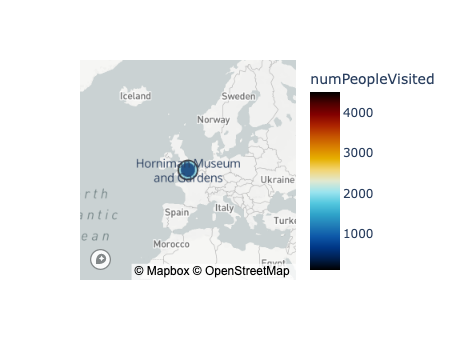

In [55]:
import plotly.express as px

# We have created an account on MapBox to get a token, so we can get a map of the world in which we can zoom.
px.set_mapbox_access_token(open(".mapbox_token").read())

# Each point on the printed map correspond to a place outputed by our search engine (the third one)
# By zooming on the map, we can get the address of each place
# And by putting the mouse on the point, we can get the title and the number of people that have visited for the places
# The size of the points depends on the score that we got from our third search engine
# The color of the points tells us about the number of people that have visited the place
reduced_df = output_search_engine[['Title', 'numPeopleVisited', 'placeAddress', 'placeAlt', 'placeLong', 'Score']]
fig = px.scatter_mapbox(reduced_df, lat="placeAlt", lon="placeLong", color="numPeopleVisited", size="Score", text="Title", color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, zoom=1)

fig.show()

We can see that all the places are concentrated in the same country (England). But, thanks to this map, we can zoom and get more details about where those places are located in UK.
You must notice that for the query 'america museum' that we have all the output places in England because the country argument of the third engine was set to England.

---
## **5. BONUS: More complex search engine**

---
## **6. Command line question**

In [2]:
# We make sure with a python script that the output of the bash script is good
# In the output of the bash script, we can't have floats because arithmetic operators don't return floats

df_out = pd.read_csv(os.getcwd()+'/locations_data.tsv', sep='\t', usecols=['numPeopleVisited', 'numPeopleWant', 'placeAddress'])

countries = ['Italy', 'Spain', 'France', 'England', 'United States']

for country in countries :
    n_places = len(df_out[df_out['placeAddress'].str.contains(country) == True])
    print("Country : ",country)
    print("Number of places that can be found in "+country+" : "+str(n_places))
    print(f"Average visit of the places of {country} : "+str(sum(df_out[df_out['placeAddress'].str.contains(country) == True].numPeopleVisited)/n_places))
    print("People that want to visit the places of England : "+str(sum(df_out[df_out['placeAddress'].str.contains(country) == True].numPeopleWant)))

Country :  Italy
Number of places that can be found in Italy : 182
Average visit of the places of Italy : 377.02197802197804
People that want to visit the places of England : 152541
Country :  Spain
Number of places that can be found in Spain : 81
Average visit of the places of Spain : 474.98765432098764
People that want to visit the places of England : 63980
Country :  France
Number of places that can be found in France : 188
Average visit of the places of France : 431.15425531914894
People that want to visit the places of England : 189646
Country :  England
Number of places that can be found in England : 364
Average visit of the places of England : 475.97527472527474
People that want to visit the places of England : 386670
Country :  United States
Number of places that can be found in United States : 4239
Average visit of the places of United States : 430.11512149091766
People that want to visit the places of England : 3959796


---
## **7. Theoretical question**

In [ ]:
with open('ApplicantsInfo.txt', 'x') as f:
    url = f'https://adm2022.s3.amazonaws.com/ApplicantsInfo.txt'
    result = requests.get(url)
    soup = bs(result.text)
    s = soup.find_all('body')
    print(s)
    f.write(str(s))

In [123]:
Application = pd.read_csv('ApplicantsInfo.txt', header=None)

In [124]:
n =Application.iloc[0]
Application.drop(0, inplace=True)
N= int(n[0][10:15])
M= int(n[0][16:20])

In [ ]:
df_average = pd.DataFrame(columns=('names','surnames','averages'))
for i in range(N):
    name = Application.iloc[i][0].split(' ')[0]
    surname = Application.iloc[i][0].split(' ')[1]
    all_points = Application.iloc[i][0].split(' ')[2:]
    count = 0
    for i in all_points:
        s = int(i)
        count += s
    average = round(count/M,2)
    df_average.loc[i]=[name, surname, average]
    
df_average.head()
df_average.describe()  

In [125]:
lista = []
for i in tqdm(range(N)):
    name = Application.iloc[i][0].split(' ')[0]
    surname = Application.iloc[i][0].split(' ')[1]
    all_points = Application.iloc[i][0].split(' ')[2:]
    count = 0
    for i in all_points:
        s = int(i)
        count += s
    average = round(count/M,2)
    lista.append((name, surname, average))

100%|██████████| 50000/50000 [00:31<00:00, 1598.19it/s]


####  BubbleSort( )

In [130]:
def BubbleSort(lista):
    N = len(lista)
    for i in range(N):  #N
        for j in range(i):  #i
            if lista[j][2] >= lista[j+1][2]:  #1
                if lista[j][2] == lista[j+1][2]:  #1
                    if lista[j][0] >= lista[j+1][0]:  #1
                        if lista[j][0] == lista[j+1][0]:  #1
                            if lista[j][1] > lista[j+1][1]: #1 
                                lista[j],lista[j+1]=lista[j+1],lista[j]  #1
                        else:
                            lista[j],lista[j+1]=lista[j+1],lista[j]  #1
                else:
                    lista[j],lista[j+1]=lista[j+1],lista[j]  #1
    return lista

In [ ]:
BubbleSort(lista)

#### MergeSort( )

In [131]:
def Merge(l1,l2):
    n=len(l1)
    m=len(l2)
    lista=[]
    i=0
    j=0
    while i < n and j < m:
        if l1[i][2] <= l2[j][2]:
            if l1[i][2] == l2[j][2]:
                if l1[i][0] <= l2[j][0]:
                    if l1[i][0] == l2[j][0]:
                        if l1[i][1] < l2[j][1]:
                            lista.append(l1[i])
                            i+=1
                        else:
                            lista.append(l2[j])
                            j+=1
                    else:
                        lista.append(l1[i])
                        i+=1
                else:
                    lista.append(l2[j])
                    j+=1
            else:
                lista.append(l1[i])
                i+=1
                
        else:
            lista.append(l2[j])
            j+=1

    while i < n:
            lista.append(l1[i])
            i += 1
    while j < m:
            lista.append(l2[j])
            j += 1
    return lista

In [132]:
def MergeSort(lista):
    if len(lista) <= 1:
        return lista
    else:
        lista1=lista[:len(lista)//2]
        lista2=lista[len(lista)//2:]
        l1=MergeSort(lista1)
        l2=MergeSort(lista2)
        return Merge(l1,l2)

In [ ]:
MergeSort(lista)

#### QuickSort( )

In [133]:

def QuickSort(lista):
    if len(lista) <= 1:
        return lista
    else:
        pivot = rdm.choice(lista)
        lista.remove(pivot)
        l1=[]
        l2=[]
        for x in lista:
            if x[2] <= pivot[2]:
                if x[2] == pivot[2]:
                    if x[0] <= pivot[0]:
                        if x[0] == pivot[0]:
                            if x[1] < pivot[1]:
                                l1.append(x)
                            else:
                                l2.append(x)
                        else:
                            l1.append(x)
                    else:
                        l2.append(x)
                else:
                    l1.append(x)
            else:
                l2.append(x)
        l= QuickSort(l1)+[pivot]+ QuickSort(l2)
        return l

In [ ]:
QuickSort(lista)

### Running time

#### BubbleSort

The BubbleSort algorithm beacome with a for loop in range $N$ 
and for every iteration do another for loop in range $i$ where $i$ ranges forom 0 to $N$. 
Every iteration do only if statement(for up to 5 times) that have costant runnig time($C_1,C_2,C_3,C_4,C_5$). When this condition do something, they invert the 2 position , that have a costant running time($C_6$). In formula:

$T(N)=N\times i(C_1+C_2+C_3+C_4+C_5+C_6)=O(N)\times O(N)\times (O(1))=O(N^2)$

#### MergeSort

The MergeSort algorithm call the Merge function, so first have a look to Merge runnnig time:
Merge has two ordered list as imput and return a ordered list.
Start definig the length of the 2 list, define the new list, and creat 2 counters, all this operation have costant runnig time($C_1$).
Now start with a while loop, that end when $i$ or $j$ become $n$ or $m$(the length of the 2 imput lists) respectively. Note that in the end of every iteration of this while loop, only one of the 2 contators($i,j$), increse. afther this while, there are other 2 while, only one of this will be executed it "finish" the one of the lists not accomplished in the firt while.
Therefore this 3 while have in total $n+m$ running time.

$$T_{Merge}(N)=T_{Merge}(n+m)=C_1+(n+m)=O(1)+O(n+m)=O(n+m)=O(N)$$

Now, we can go back to the Sort algorithm a recursive algorithm, which has as imput a list(with length $N$). The initial contition have costant running time($C_1$) and after we define 2 list($C_2$), we do two recursive calls of the two list(with lengths $\frac{N}{2}$), and we return with Merge function.



$$
T_{MSort}(N)=
\begin{cases}
C_1, & \text{if $N=1$,} \\
C_2T_{Merge}(N)+2T_{MSort}(\frac{N}{2}), & \text{if $N > 1$.}
\end{cases}
$$

Let's see when $N > 1$:

$T_{MSort}(N)=C_2T_{Merge}(N)+2T_{MSort}(\frac{N}{2})=C_2 N+ 2T_{MSort}(\frac{N}{2})=$

$=C_2 N + 2\left[C_2\frac{N}{2} + 2T_{MSort}(\frac{N}{4}) \right]=C_2 N + C_2 N + 4T_{MSort}(\frac{N}{4})= $

$=C_2 N + C_2 N + 4\left[C_2\frac{N}{4}+ 2T_{MSort}(\frac{N}{8})\right]=$

$=C_2 N + C_2 N + C_2 N + 8T_{MSort}(\frac{N}{8})=$

$...$

$=i C_2 N + 2^iT_{MSort}(\frac{N}{2^i})=$

$\text{For   } i = \log_2 N, \text{we have}: 2^i=2^{ \log_2 N}=N\text{   therefore, with a sostitution:}    $

$=C_2 N \log_2 N  + N T_{MSort}(1)=$

$=C_2 N \log_2 N  + N C_1= O(1)O(N)O(\log_2 N)+ O(1)O(N)$

$=O(N \log_2 N)+ O(N)=O(N\log_2 N)$


#### QuickSort

The QuickSort is also a recurvise function wich has as imput a list. start with initial condition that have costant runnig time ($C_1$), afther define 2 list and a pivot($C_2$), remuve it to the list(worst case $O(n)$),  and start a for loop in range $N$(the length of the imput list). for every iteration(for every element of the list), with an if chain(costant time) put the element of the list in the one or the second list previously declared rispectively if the element is lower or bigger than the pivot.
We need all this case of if condition becose the element of the list are Triple, so we decide to sort first for the last parameter(the averege),afther for the alfabetic order, respectively name(first parameter), and surname(second parameter). that's not a big problem for the computation, because the chain of if has also costant running time($C_3$), and in the end of every iteration we will only have one assignment($C_4$).

$$
T(n)=
\begin{cases}
C_1, & \text{if $n = 1$,} \\
C_2+T_{remuve}(n)+C_3+C_4+T(n-i)+T(i), & \text{if $n > 1$.}
\end{cases} 
$$

$$
=
\begin{cases}
C_1, & \text{if $n = 1$,} \\
O(n)+ O(1)+T(N-i)+T(i), & \text{if $n > 1$.}
\end{cases}
$$


Let's look at this term:  $T(n-i)+T(i)$   separately:
$i$ is random, so in the very best case $i$ is always in the center of the imput list, so we have: $T(n-\frac{n}{2})+T(\frac{n}{2})=2T(\frac{n}{2})= O(\log_2 n)$ 

But in the very worts case we have $i$ at the ends of the range, if is 1, at the start we will have $T(n-1)+T(1)$ were $T(1)$ have costant running time, if is $n-1$ in the end we will have $T(n-(n-1))+T(n-1)=T(1)+T(n-1)=O(n)$

therefore we can write:

$ O(\log_2 n) \leq T(n-i)+T(i) \leq  O(n) $

According that $T_{remuve}(n)$ is a $O(n)$ for the list, we can write:

$ O(n)O(\log_2 n) \leq T(n) \leq  O(n)O(n) $

$O(n \log_2 n) \leq T(n) \leq  O(n^2) $


In [136]:

start1 = time.time()
BubbleSort(lista[:10000])
end1 = time.time()
delta_time1= end1 - start1
print(f"Execution time of the BubbleSort is: {round(delta_time1,2)} seconds")


Execution time of the BubbleSort is: 23.6 seconds


In [134]:
start2 = time.time()
MergeSort(lista[:10000])
end2 = time.time()
delta_time2= end2 - start2
print(f"Execution time of the MergeSort is: {round(delta_time2,2)} seconds")


Execution time of the MergeSort is: 0.08 seconds


In [138]:
start3 = time.time()
QuickSort(lista[:10000])
end3 = time.time()
delta_time3= end3 - start3
print(f"Execution time of the QuickSort is: {round(delta_time3,2)} seconds")


Execution time of the QuickSort is: 0.07 seconds


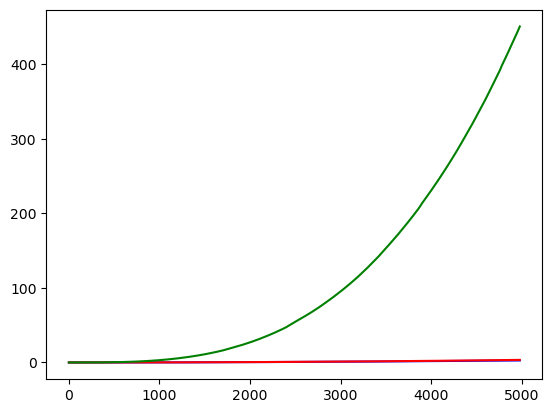

In [139]:

r = range(0,5000,20)
start_Quick = time.time()
dt_Quick  = []
dt_Merge  = []
dt_Bubble = []
for N in r: 
    QuickSort(lista[:N])
    dt_Quick.append(time.time()-start_Quick)
plt.plot(r, dt_Quick, color="blue")

start_Merge = time.time()
for N in r: 
    MergeSort(lista[:N])
    dt_Merge.append(time.time()-start_Merge)
plt.plot(r, dt_Merge, color="red")

start_Bubble = time.time()
for N in r: 
    BubbleSort(lista[:N])
    dt_Bubble.append(time.time()-start_Bubble)
plt.plot(r, dt_Bubble, color="green")